# Red Wine Quality Project

This study will consider Vinho Verde, a unique product from the Minho (north-west) region of Portugal. Medium in alcohol, is it particularly appreciated due to its freshness (specially in the summer). This wine accounts for 15% of the total Portuguese production, and around 10% is exported, mostly white wine. In this work, we will analyze the two most common variants, white and red (rose is also produced), from the demarcated region of vinho verde. The data were collected from May/2004 to February/2007 using only protected designation of origin samples that were tested at the official certification entity (CVRVV). The CVRVV is an inter-professional organization with the goal of improving the quality and marketing of vinho verde. The data were recorded by a computerized system (iLab), which automatically manages the process of wine sample testing from producer requests to laboratory and sensory analysis. Each entry denotes a given test (analytical or sensory) and the final database was exported into a single sheet (.csv).
During the preprocessing stage, the database was transformed in order to include a distinct wine sample (with all tests) per row. To avoid discarding examples, only the most common physicochemical tests were selected. Since the red and white tastes are quite different, the analysis will be performed separately, thus two datasets 1 were built with 1599 red and 4898 white examples. Regarding the preferences, each sample was evaluated by a minimum of three sensory assessors (using blind tastes), which graded the wine in a scale that ranges from 0 (very bad) to 10 (excellent). The final sensory score is given by the median of these evaluations. **(Cortez et al., 2009)**

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from typing import List
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.graphics.regressionplots import plot_ccpr
from statsmodels.graphics.regressionplots import add_lowess
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
}

sns.set_theme(
    context="notebook", style="whitegrid", rc=custom_params
)

pd.set_option("display.precision", 2)

# Data Loading and Inspection

In [2]:
df = pd.read_csv('winequality-red.csv')

## Missing Values

In [3]:
pd.DataFrame(df.isna().any()).T

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,False,False,False,False,False,False,False,False,False,False,False,False


No missing values.

## Duplicates

In [4]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.08,11.0,34.0,1.00,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.10,25.0,67.0,1.00,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.09,15.0,54.0,1.00,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.07,17.0,60.0,1.00,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.08,11.0,34.0,1.00,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.60,0.08,2.0,0.09,32.0,44.0,0.99,3.45,0.58,10.5,5
1595,5.9,0.55,0.10,2.2,0.06,39.0,51.0,1.00,3.52,0.76,11.2,6
1596,6.3,0.51,0.13,2.3,0.08,29.0,40.0,1.00,3.42,0.75,11.0,6
1597,5.9,0.65,0.12,2.0,0.07,32.0,44.0,1.00,3.57,0.71,10.2,5


In [5]:
df.duplicated().sum()

240

In [6]:
df.duplicated().sum() / len(df)

0.150093808630394

15% of datapoints are seemingly duplicated. Though it's hard to say if they are indeed duplicates since there are no categorical variables by which duplicated values could be identified as such. On the other hand it is difficult to believe that 15% of physicochemical
variable combinations would have duplicates. The origin study of the dataset suggests that the data was collected in a seemingly meticulous lab setting, therefore we will make the assumption that no data in the sample is duplicated.

# Outliers

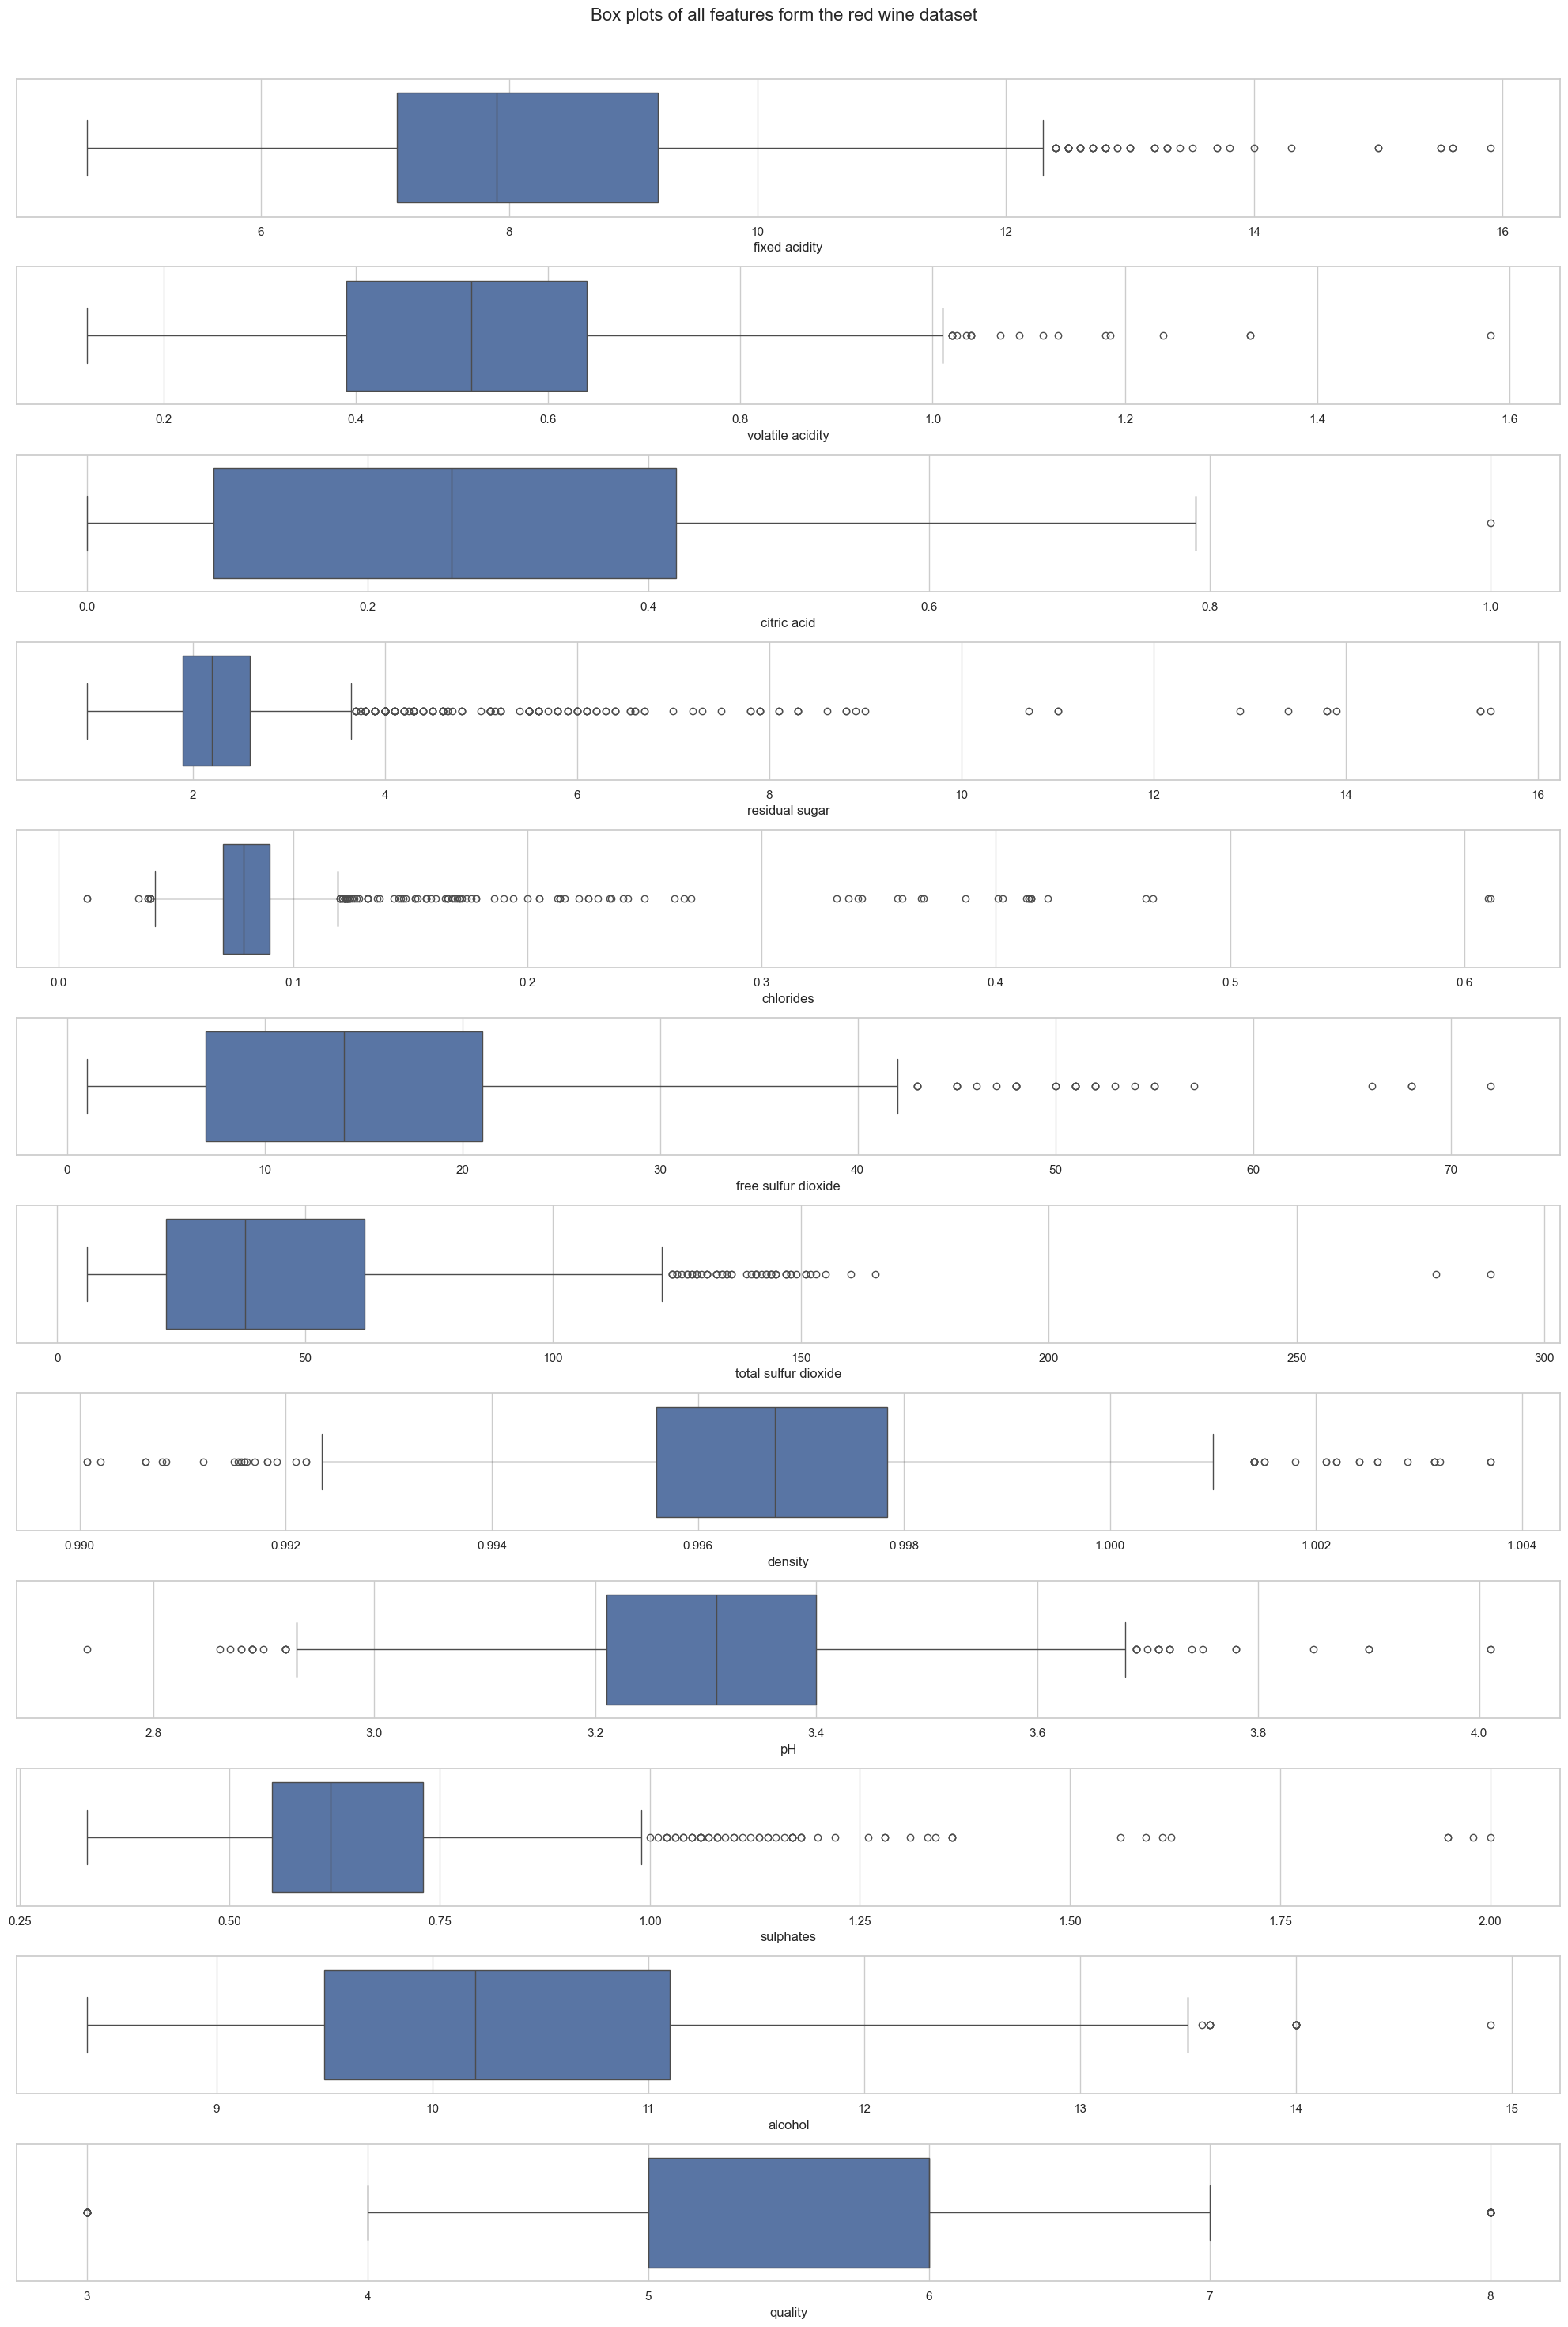

In [7]:
fig, ax = plt.subplots(12,1, figsize=(20, 30))
for index, axes in enumerate(ax):
    sns.boxplot(df.iloc[:, index], ax=axes, orient='h')
    axes.spines[['top', 'right']].set_visible(True)
fig.suptitle('Box plots of all features form the red wine dataset', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95);

The data contains multiple outliers according to the usual outlier detection formula. However, there doesn't seem to be a necessity to drop any of the datapoints since nothing seems erroneous and not suitable for our purposes.

# EDA

## The Distribution of Numeric Features

In [8]:
def plot_dist_all(df):
    
    df_long = df.melt(var_name='Column', value_name='Value')
    g = sns.FacetGrid(df_long, col='Column', col_wrap=3, sharex=False, sharey=False)
    g.map(sns.histplot, 'Value', kde=True)
    for ax, title in zip(g.axes.flat, df.drop('quality', axis=1).columns):
        ax.set_title(title)
    return plt.show()

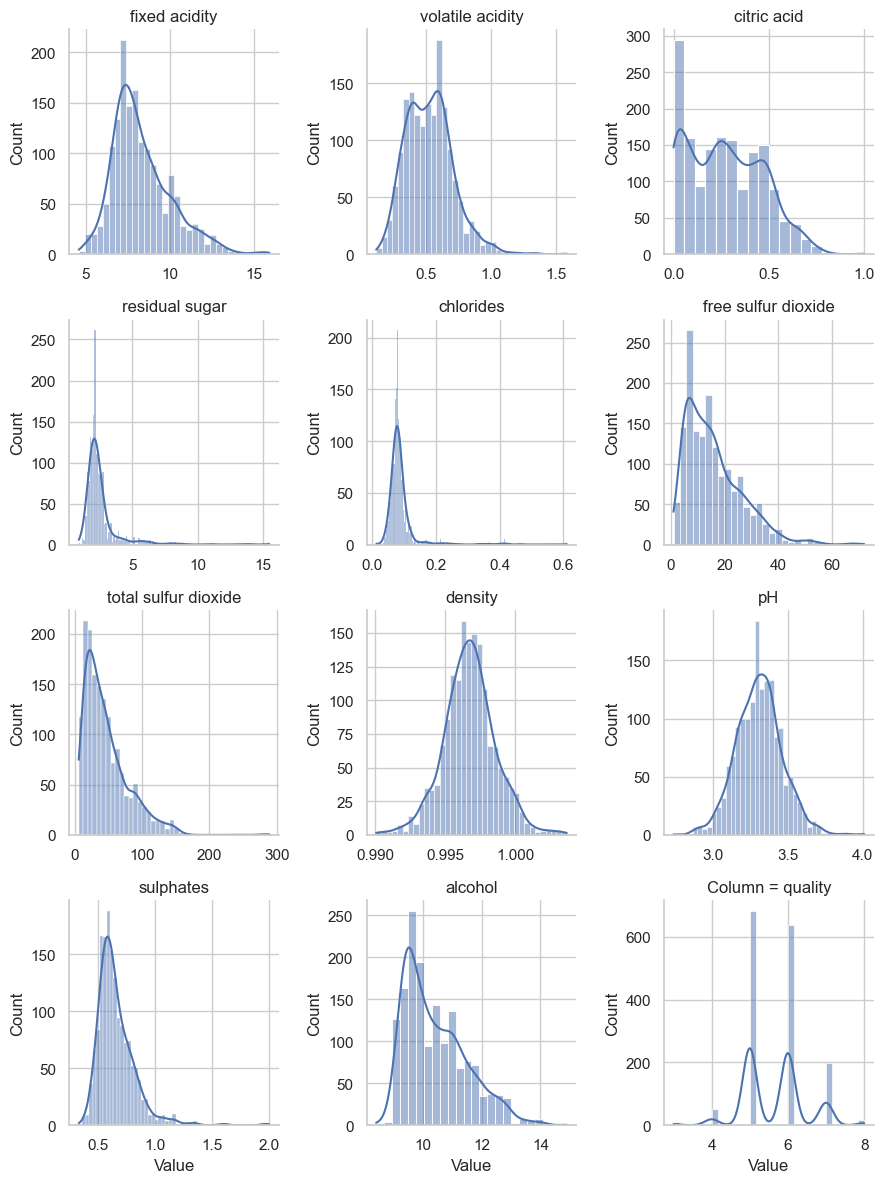

In [9]:
plot_dist_all(df)

Many of the features have skewed distributions.

## The Proportions of Quality Ratings

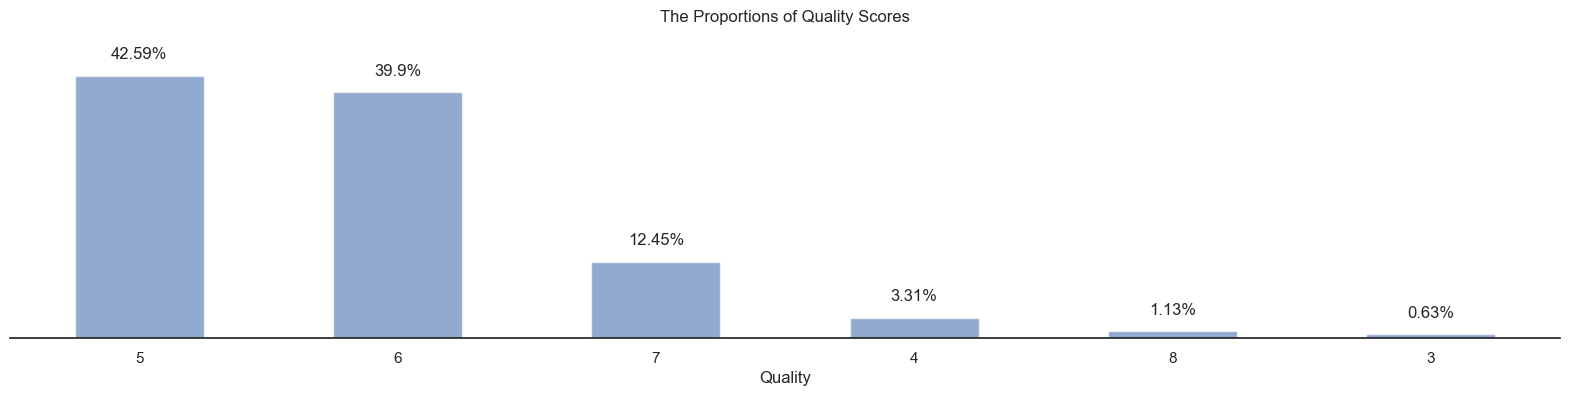

In [10]:
with sns.axes_style("white"): 
    (df
 .quality
 .value_counts(normalize=True)
 .mul(100)
 .plot(kind='bar', legend=False, ylabel='Percent',
       xlabel='Quality', ylim=(0,50), alpha=0.6, figsize=(20,4), rot=0)
 .set_title('The Proportions of Quality Scores')
    )
ax = plt.gca()
ax.spines[['top', 'left', 'right']].set_visible(False)
for p in ax.patches:
    ax.annotate(
    f'{round(p.get_height(), 2)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_ylabel('');

The Quality score is the median across all of the scores given by the testers for each sample. Thus the somewhat strange lack of top scores. Apparently there were no wine samples that would satisfy all of the testers. Generally, scores of 5 and 6 are substantially the most comon ones.

## Correlations

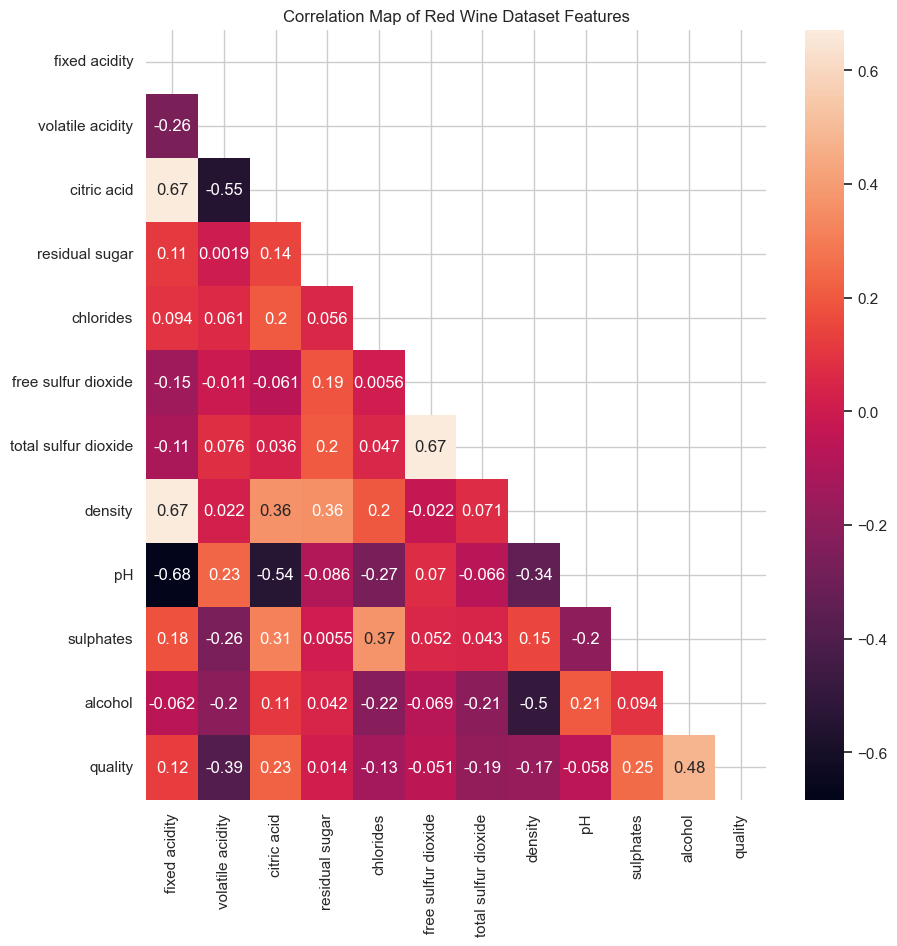

In [11]:
corr= df.corr()
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, mask=matrix)
ax.set_title('Correlation Map of Red Wine Dataset Features');

Volatile acidity, which is the perception of vinegar odor or in other words the presence of low molecular weight fatty acids seem to  moderately negatively correlate with the presence of citric acid. Density also correlates somewhat strongly with fixed acidity. Negative correlation of alcohol and density makes sense since alcohol is less dense than water.\
\
Correlated pairs of interest:
- Alcohol and Quality
- Volatile Acidity and Quality
- Citric Acidity and Quality

## Alcohol and Quality

The feature of quality seems to correlate most strongly with alcohol:

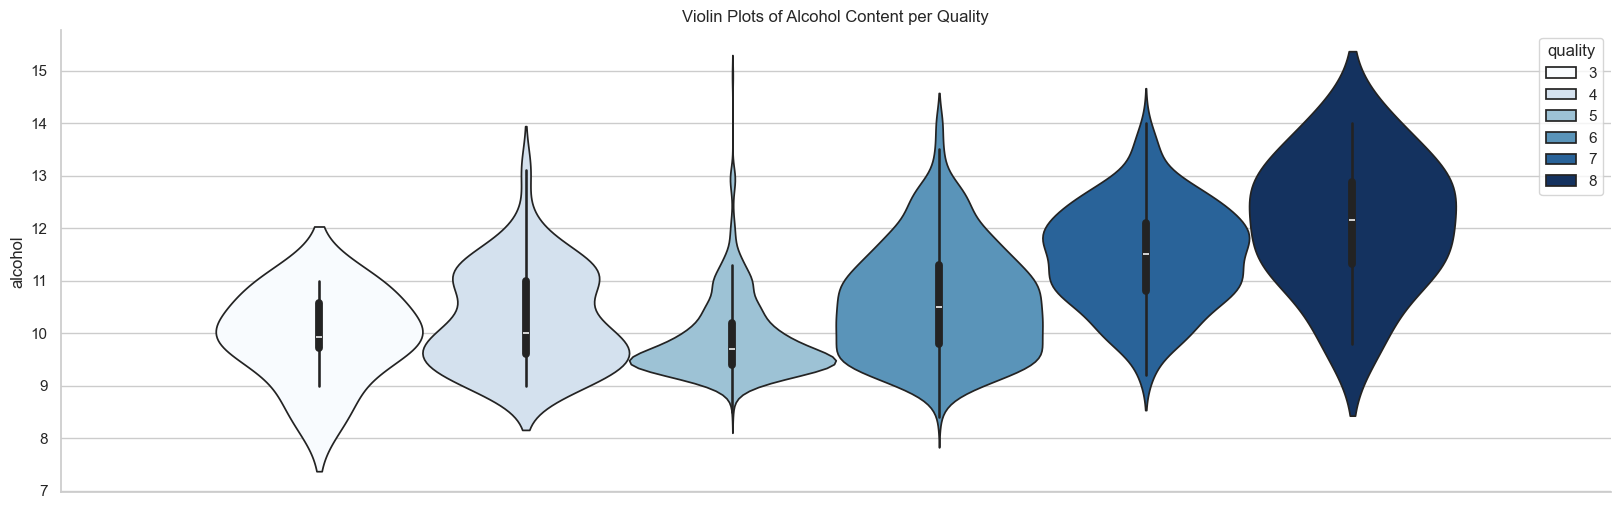

In [12]:
(sns.violinplot(data=df, hue='quality', y='alcohol', palette='Blues')
 .set_title('Violin Plots of Alcohol Content per Quality')
)
plt.gcf().set_size_inches(20,6);

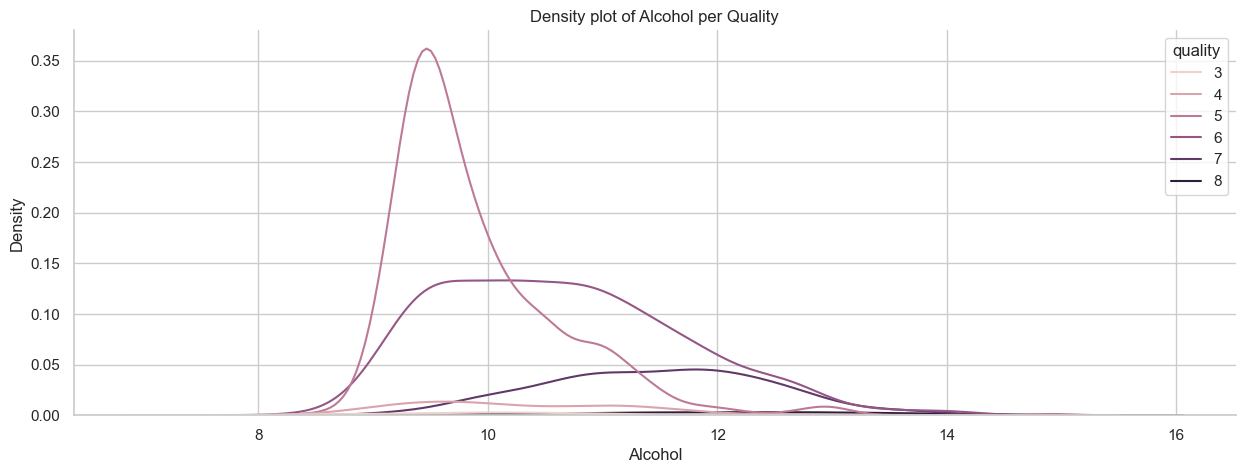

In [13]:
(sns.kdeplot(data=df, x='alcohol', hue='quality')
 .set_xlabel('Alcohol'))
plt.gcf().set_size_inches(15,5)
plt.gca().set_title('Density plot of Alcohol per Quality');

In [14]:
print(f'Maximum amount of alcohol among lowest quality wines:\t' 
    + f'{df[df["quality"] == 3]["alcohol"].max()}\n'

    + f'Minimum amount of alcohol among highest quality wines:\t' 
    + f'{df[df["quality"] == 8]["alcohol"].min()}')

Maximum amount of alcohol among lowest quality wines:	11.0
Minimum amount of alcohol among highest quality wines:	9.8


In [15]:
(df[df['quality'] > 4][['alcohol', 'quality']]
 .corr()
 .loc['alcohol', 'quality']
)

0.5218858463056206

In [16]:
(df[df['quality'] <= 4][['alcohol', 'quality']]
 .corr()
 .loc['alcohol', 'quality']
)

0.12440529794159136

- The distribution seems to shift from right-skewed to normal with increase in grade.
- The top quality wines don't have any samples below 9.8% alcohol in the group. Same goes for the lowest quality wines which don't include anything above 11%.
- The first three grade distributions don't show any particular upwards quality trend with respect to alcohol. Grade 5-8 is when the positive association becomes visible.

## Volatile Acidity <a id="volatile_acidity"></a>

The second largest correlation with quality was volatile acidity:

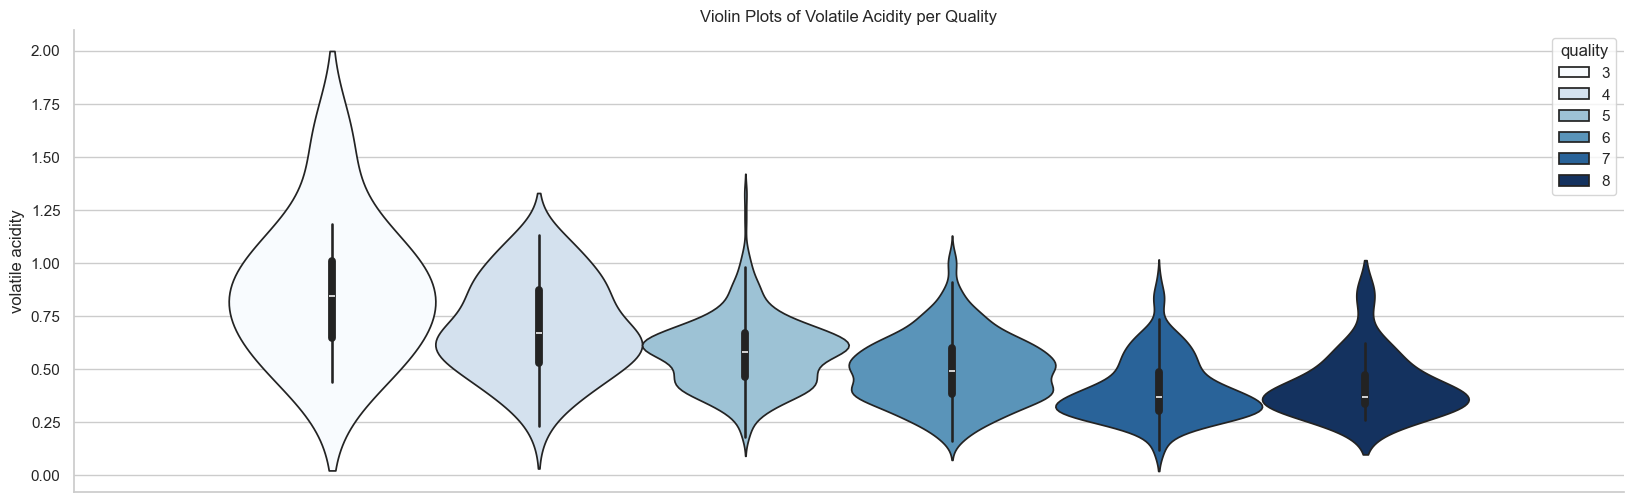

In [17]:
(
    sns.violinplot(data=df, hue='quality', y='volatile acidity', palette='Blues')
    .set_title('Violin Plots of Volatile Acidity per Quality')
)
plt.gcf().set_size_inches(20,6);

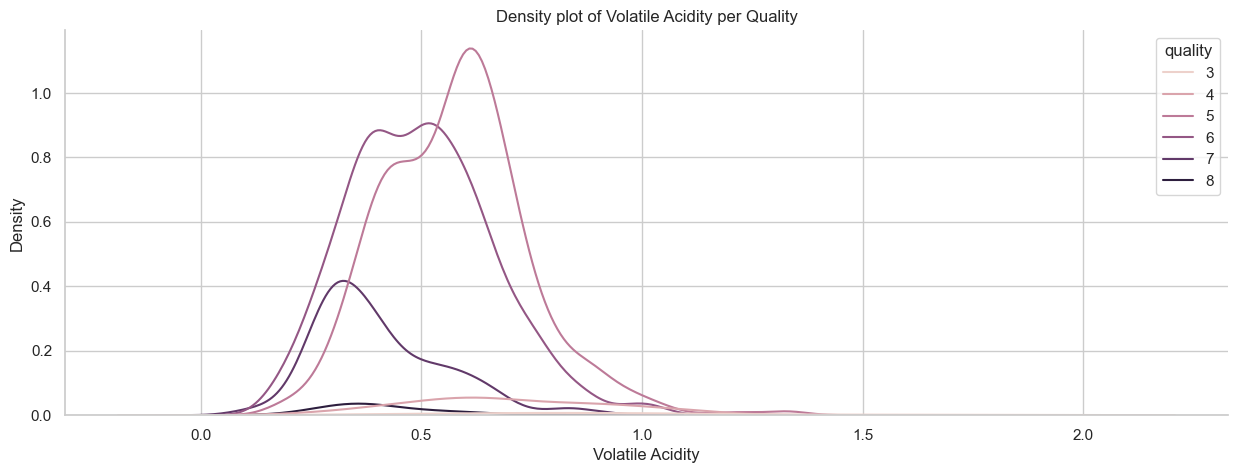

In [18]:
(sns.kdeplot(data=df, x='volatile acidity', hue='quality')
 .set_xlabel('Volatile Acidity'))
plt.gcf().set_size_inches(15,5)
plt.gca().set_title('Density plot of Volatile Acidity per Quality');

In [19]:
print(f'Grade 7 Volatile Acidity Mean:\t'
    + f"{df[df['quality'] == 7]['volatile acidity'].mean()}\n"
    + f'Grade 8 Volatile Acidity Mean:\t'
    + f"{df[df['quality'] == 8]['volatile acidity'].mean()}")

Grade 7 Volatile Acidity Mean:	0.40391959798994975
Grade 8 Volatile Acidity Mean:	0.4233333333333334


The two highest grades follow a different relationship then the rest. The lower scores exhibit a negative relationship.

# Inference

## Mean Volatile Acidity

Since there was a slight increase in mean volatile acidity from grade 7 to grade 8, it raises a question wether that increase is meaningful in some way.\
Click [**here**](#volatile_acidity) to jump to the relevant EDA section.

- **Research Question:** Is the mean volatile acidity difference statistically significant?

- **Populations:** All grade 8 wines and all grade 7 red vinho verde wines.

- **Parameter of Interest:** $\mu_1 - \mu_2$, where $\mu_1$ and $\mu_2$ are the volatile acidity means for grade 8 and grade 7 wines, respectively.

- **Null Hypothesis:** $H_0: \mu_1 = \mu_2$.

- **Alternative Hypothesis:** $H_1: \mu_1 \neq \mu_2$.

- **Significance Level:** $\alpha = 0.05$.

In [20]:
quality_8_vol = df[df['quality'] == 8]['volatile acidity']
quality_7_vol = df[df['quality'] == 7]['volatile acidity']

In [21]:
quality_8_vol.count(), quality_7_vol.count()

(18, 199)

The sample size of 18 is on the low side, therefore the resampling techniques will be used.

### Assumptions:

- **Independent groups** <span style="font-size: 25px;">&#10004;</span>
- **Simple random sample**&#x2753;

It's unclear as whether the sample represents the population well.

In [22]:
def permutation_test(a:List[float], b:List[float], permutations:int) -> float:
    count = 0
    observed_diff = np.mean(a) - np.mean(b)
    for _ in range(permutations):
        combined = np.concatenate([a, b])
        np.random.shuffle(combined)
        group1 = combined[:len(a)]
        group2 = combined[len(a):]
        perm_diff = np.mean(group1) - np.mean(group2)
        if abs(perm_diff) >= abs(observed_diff):
            count += 1
    return count / permutations

In [23]:
permutation_test(list(quality_7_vol.values), list(quality_8_vol.values), 100_000)

0.58768

Based on our sample and our p-value, we don't reject the null hypothesis. In this case, we conclude that there is not a significant difference between the population mean volatile acidity measurements for grade 8 and 7 red vinho verde wines.

# Modeling Alcohol

## Assesing Numerical Issues

### Multicollinearity

We calculate the variance inflation factor for our features. The threshold of **VIF > 10** will be used to indicate substantial multicollinearity of independent variables:

In [24]:
df.columns = [i.replace(' ', '_') for i in df.columns]

In [25]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [26]:
X = df.drop(['alcohol'], axis=1)

In [27]:
calc_vif(X).T

,0,1,2,3,4,5,6,7,8,9,10
variable,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,quality
VIF,73.73,17.89,8.78,4.63,6.44,6.45,6.46,1523.55,1032.87,22.36,65.5


Very high. We iterate, droping features with high VIF trying to see if by removing a few features we can get a reasonable result:

In [28]:
X = df.drop(['citric_acid', 'free_sulfur_dioxide', 'pH', 'alcohol', 'density'], axis=1)

In [29]:
calc_vif(X).T

,0,1,2,3,4,5,6
variable,fixed_acidity,volatile_acidity,residual_sugar,chlorides,total_sulfur_dioxide,sulphates,quality
VIF,21.49,7.45,4.55,5.56,3.14,21.75,30.42


In [30]:
X = df.drop(['citric_acid', 'free_sulfur_dioxide', 'pH', 'alcohol', 'density', 'quality'], axis=1)

In [31]:
calc_vif(X).T

,0,1,2,3,4,5
variable,fixed_acidity,volatile_acidity,residual_sugar,chlorides,total_sulfur_dioxide,sulphates
VIF,15.59,6.74,4.47,5.33,3.14,15.57


In [32]:
X = df.drop(['citric_acid', 'free_sulfur_dioxide', 'pH', 'alcohol', 'density', 'quality', 'fixed_acidity'], axis=1)

In [33]:
calc_vif(X).T

,0,1,2,3,4
variable,volatile_acidity,residual_sugar,chlorides,total_sulfur_dioxide,sulphates
VIF,5.99,4.11,5.33,3.13,9.09


It seems that we would have to drop nearly all of the features to avoid high VIF scores.

### Scaling

The differences of scales in each feature are extreame which in some edge cases would artificially inflate the VIF score. Therefore, we attempt to scale the data to remedy this:

In [34]:
def scale_z(df):
    scaled_df = pd.DataFrame(columns=df.columns, index=df.index)
    for column in df.columns:
        col_mean = df[column].mean()
        col_std = df[column].std()
        scaled_df[column] = df[column].apply(lambda x: (x - col_mean) / col_std if col_std > 0 else 0)
    return scaled_df

In [35]:
df_scaled = scale_z(df)
X = df_scaled.drop(['alcohol'], axis=1)
calc_vif(X).T

,0,1,2,3,4,5,6,7,8,9,10
variable,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,quality
VIF,5.68,1.85,3.06,1.31,1.5,1.97,2.21,3.0,2.45,1.41,1.46


Scaling all of the features to Z scale seemed to have worked.

## Model Selection

We will iteratively drop features by their p-value and record AIC, BIC, $R^2$ and RMSE.

In [36]:
aic = list()
bic = list()
dropped = list()
adj_r_squares = list()
rmse = list()

to_exclude = ['alcohol']
ivs = [i for i in df.columns if i not in to_exclude]
added_ivs = ' + '.join(ivs)
formula = f'alcohol ~ {added_ivs}'
for _ in range(len(df_scaled.columns) - 1):
    model = sm.OLS.from_formula(formula, data=df_scaled)
    result = model.fit()
    aic.append(result.aic)
    bic.append(result.bic)
    rmse.append(np.sqrt(np.mean(result.resid**2)))
    adj_r_squares.append(result.rsquared_adj)
    dropped.append(to_exclude[-1])
    to_exclude.append(np.absolute(result.pvalues[1:]).idxmax())
    ivs = [i for i in df.columns if i not in to_exclude]
    added_ivs = ' + '.join(ivs)
    formula = f'alcohol ~ {added_ivs}'

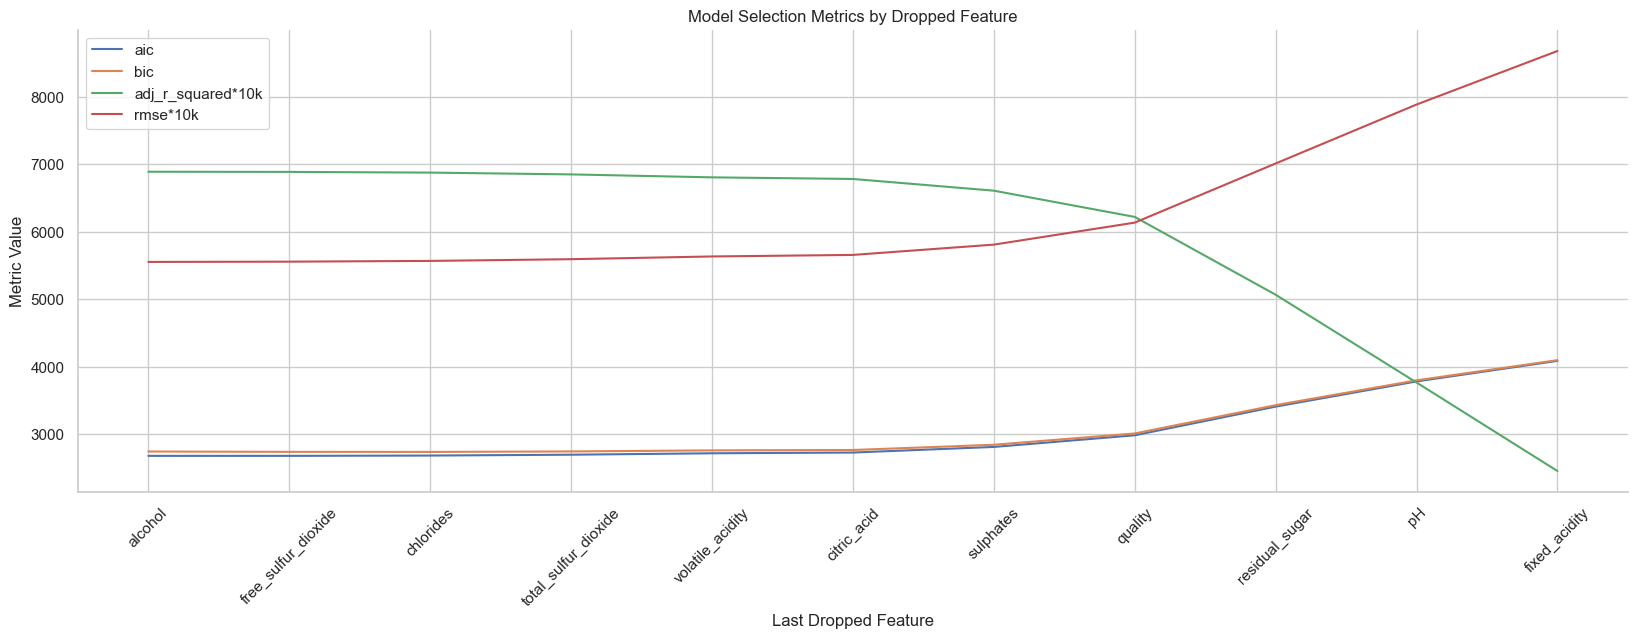

In [37]:
selection_result = pd.DataFrame({'dropped': dropped,
'aic': aic, 'bic': bic, 'adj_r_squared*10k': adj_r_squares, 'rmse*10k':rmse})
selection_result['adj_r_squared*10k'] = selection_result['adj_r_squared*10k'].mul(10_000)
selection_result['rmse*10k'] = selection_result['rmse*10k'].mul(10_000)

selection_result.reset_index(inplace=True)

ax = selection_result.plot(x='index', kind='line', figsize=(20, 6))

ax.set_xticks(selection_result.index)
ax.set_xticklabels(selection_result['dropped'], rotation=45) 

ax.set_xlabel('Last Dropped Feature')
ax.set_ylabel('Metric Value')
ax.set_title('Model Selection Metrics by Dropped Feature');

The best trade-off seems to be dropping:
- alcohol
- free_sulfur_dioxide
- chlorides
- total_sulfur_dioxide
- volatile_acidity
- citric_acid

## Model Specification

The initial model will follow the structure:
$$
\begin{align*}
\text{Alcohol} = & \ \beta_0 + \beta_1 \times \text{Fixed Acidity}  + \beta_2 \times \text{Residual Sugar}  \\
& + \beta_3 \times \text{pH} + \beta_4 \times \text{Density} \\
& + \beta_5 \times \text{Sulphates} + \beta_6 \times \text{Quality}
\end{align*}
$$

In [38]:
to_exclude = ['citric_acid', 'free_sulfur_dioxide',
              'chlorides', 'total_sulfur_dioxide','volatile_acidity', 'alcohol']
ivs = [i for i in df_scaled.columns if i not in to_exclude]
added_ivs = ' + '.join(ivs)
formula = f'alcohol ~ {added_ivs}'

model = sm.OLS.from_formula(formula, data=df_scaled)
result = model.fit()

## Predicting the alcohol column

Inverting standardization:

In [39]:
df['predicted_alcohol'] = result.predict(df_scaled) * df.alcohol.std() + df.alcohol.mean()

In [40]:
df[[*ivs, 'alcohol', 'predicted_alcohol']]

,fixed_acidity,residual_sugar,density,pH,sulphates,quality,alcohol,predicted_alcohol
0,7.4,1.9,1.00,3.51,0.56,5,9.4,9.64
1,7.8,2.6,1.00,3.20,0.68,5,9.8,9.57
2,7.8,2.3,1.00,3.26,0.65,5,9.8,9.58
3,11.2,1.9,1.00,3.16,0.58,6,9.8,10.58
4,7.4,1.9,1.00,3.51,0.56,5,9.4,9.64
...,...,...,...,...,...,...,...,...
1594,6.2,2.0,0.99,3.45,0.58,5,10.5,10.48
1595,5.9,2.2,1.00,3.52,0.76,6,11.2,10.89
1596,6.3,2.3,1.00,3.42,0.75,6,11.0,10.39
1597,5.9,2.0,1.00,3.57,0.71,5,10.2,10.55


## Assumptions and diagnostics

### Homoscedasticity

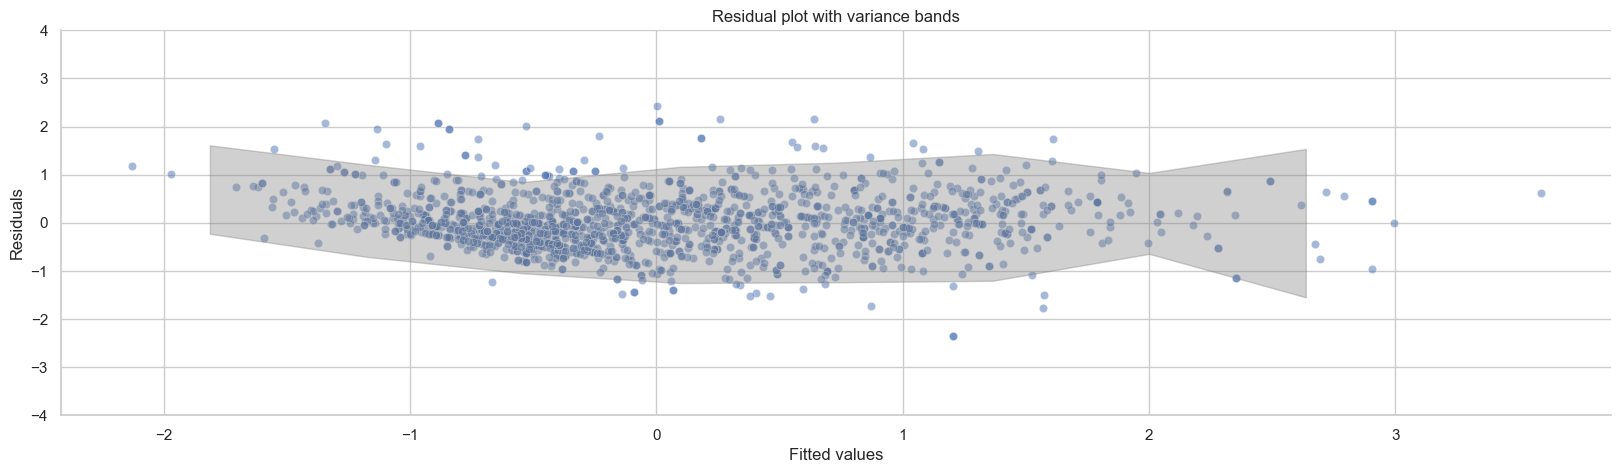

In [41]:
pp = sns.scatterplot(x=result.fittedvalues, y=result.resid, alpha=0.5)
pp.set_xlabel("Fitted values")
pp.set_ylabel("Residuals")

num_bins = 10
bins = np.linspace(result.fittedvalues.min(), result.fittedvalues.max(), num_bins)
bin_indices = np.digitize(result.fittedvalues, bins)
bin_means = [result.resid[bin_indices == i].mean() for i in range(1, num_bins)]
bin_std = [result.resid[bin_indices == i].std() for i in range(1, num_bins)]
bin_centers = (bins[:-1] + bins[1:]) / 2  

for std_multiplier in [-2, 2]:  
    pp.fill_between(bin_centers, 
                    np.array(bin_means) + std_multiplier * np.array(bin_std), 
                    np.array(bin_means) - std_multiplier * np.array(bin_std), 
                    color='gray', alpha=0.2)
    
plt.gcf().set_size_inches(20,5)
plt.gca().set_title('Residual plot with variance bands')
plt.gca().set_ylim(-4,4);

The residuals indicate a roughly linear relationship, although the model underestimates the values for the lower range. Variance seems to be roughly even.

### Multicollinearity

Since we have both fixed acidity and pH amongst our predictors let's recompute VIF once more with the current set.

In [42]:
X = df_scaled.drop(to_exclude, axis=1)
calc_vif(X).T

,0,1,2,3,4,5
variable,fixed_acidity,residual_sugar,density,pH,sulphates,quality
VIF,3.76,1.24,2.73,2.07,1.15,1.32


Nothing problematic.

### Normally distributed residuals

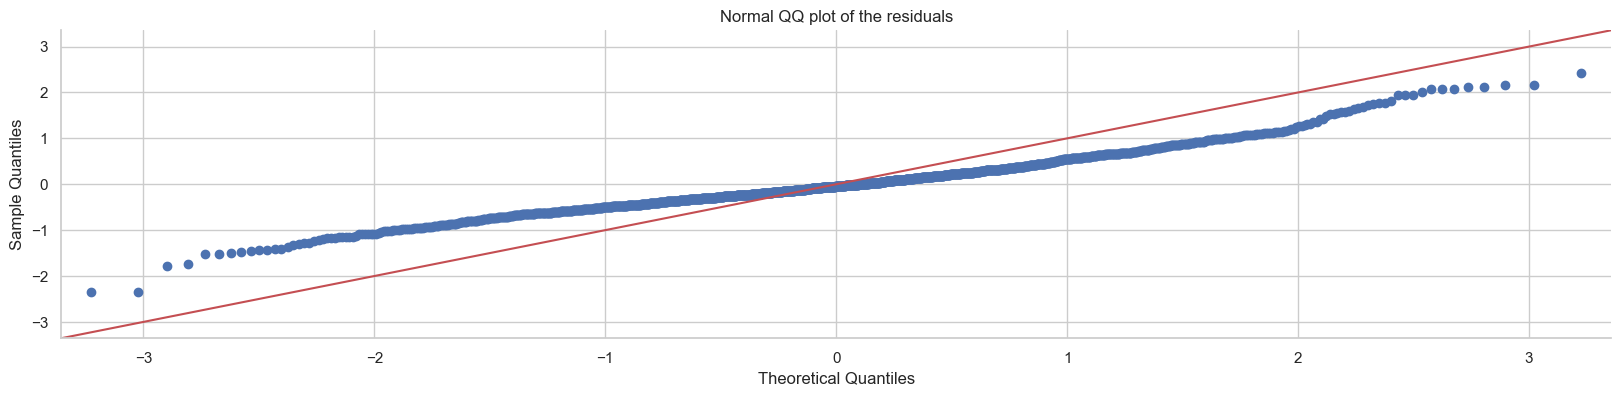

In [43]:
fig = sm.qqplot(result.resid, line ='45')
fig.set_size_inches(20, 4)
ax = plt.gca()
ax.set_title('Normal QQ plot of the residuals');

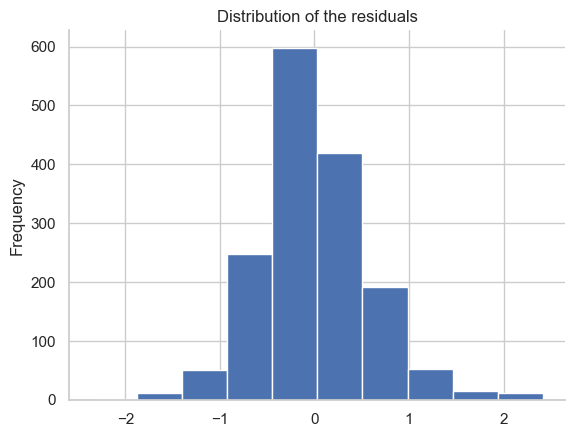

In [44]:
result.resid.plot(kind='hist').set_title('Distribution of the residuals');

Residuals are roughly normally distributed.

## Influential Points

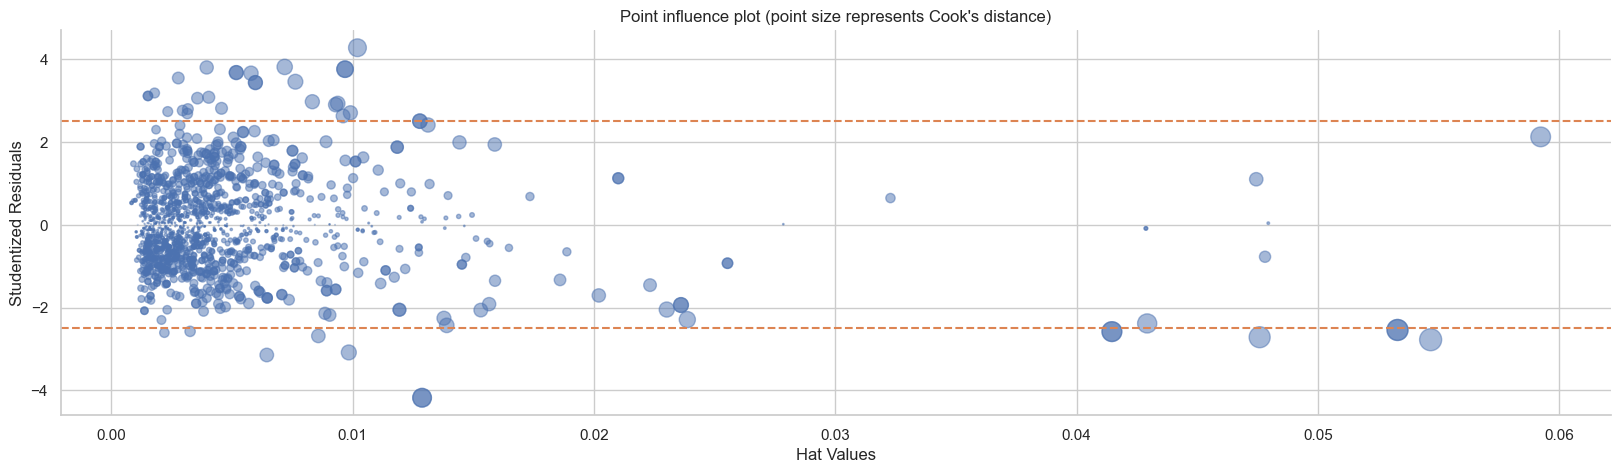

In [45]:
influence = OLSInfluence(result)
fig, ax = plt.subplots(figsize=(20, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal,
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)
ax.set_xlabel('Hat Values')
ax.set_ylabel('Studentized Residuals')
ax.set_title('Point influence plot (point size represents Cook\'s distance)');

Since the sample size is relatively large the few high-leverage points shouldn't be a big problem.

## Partial Residuals

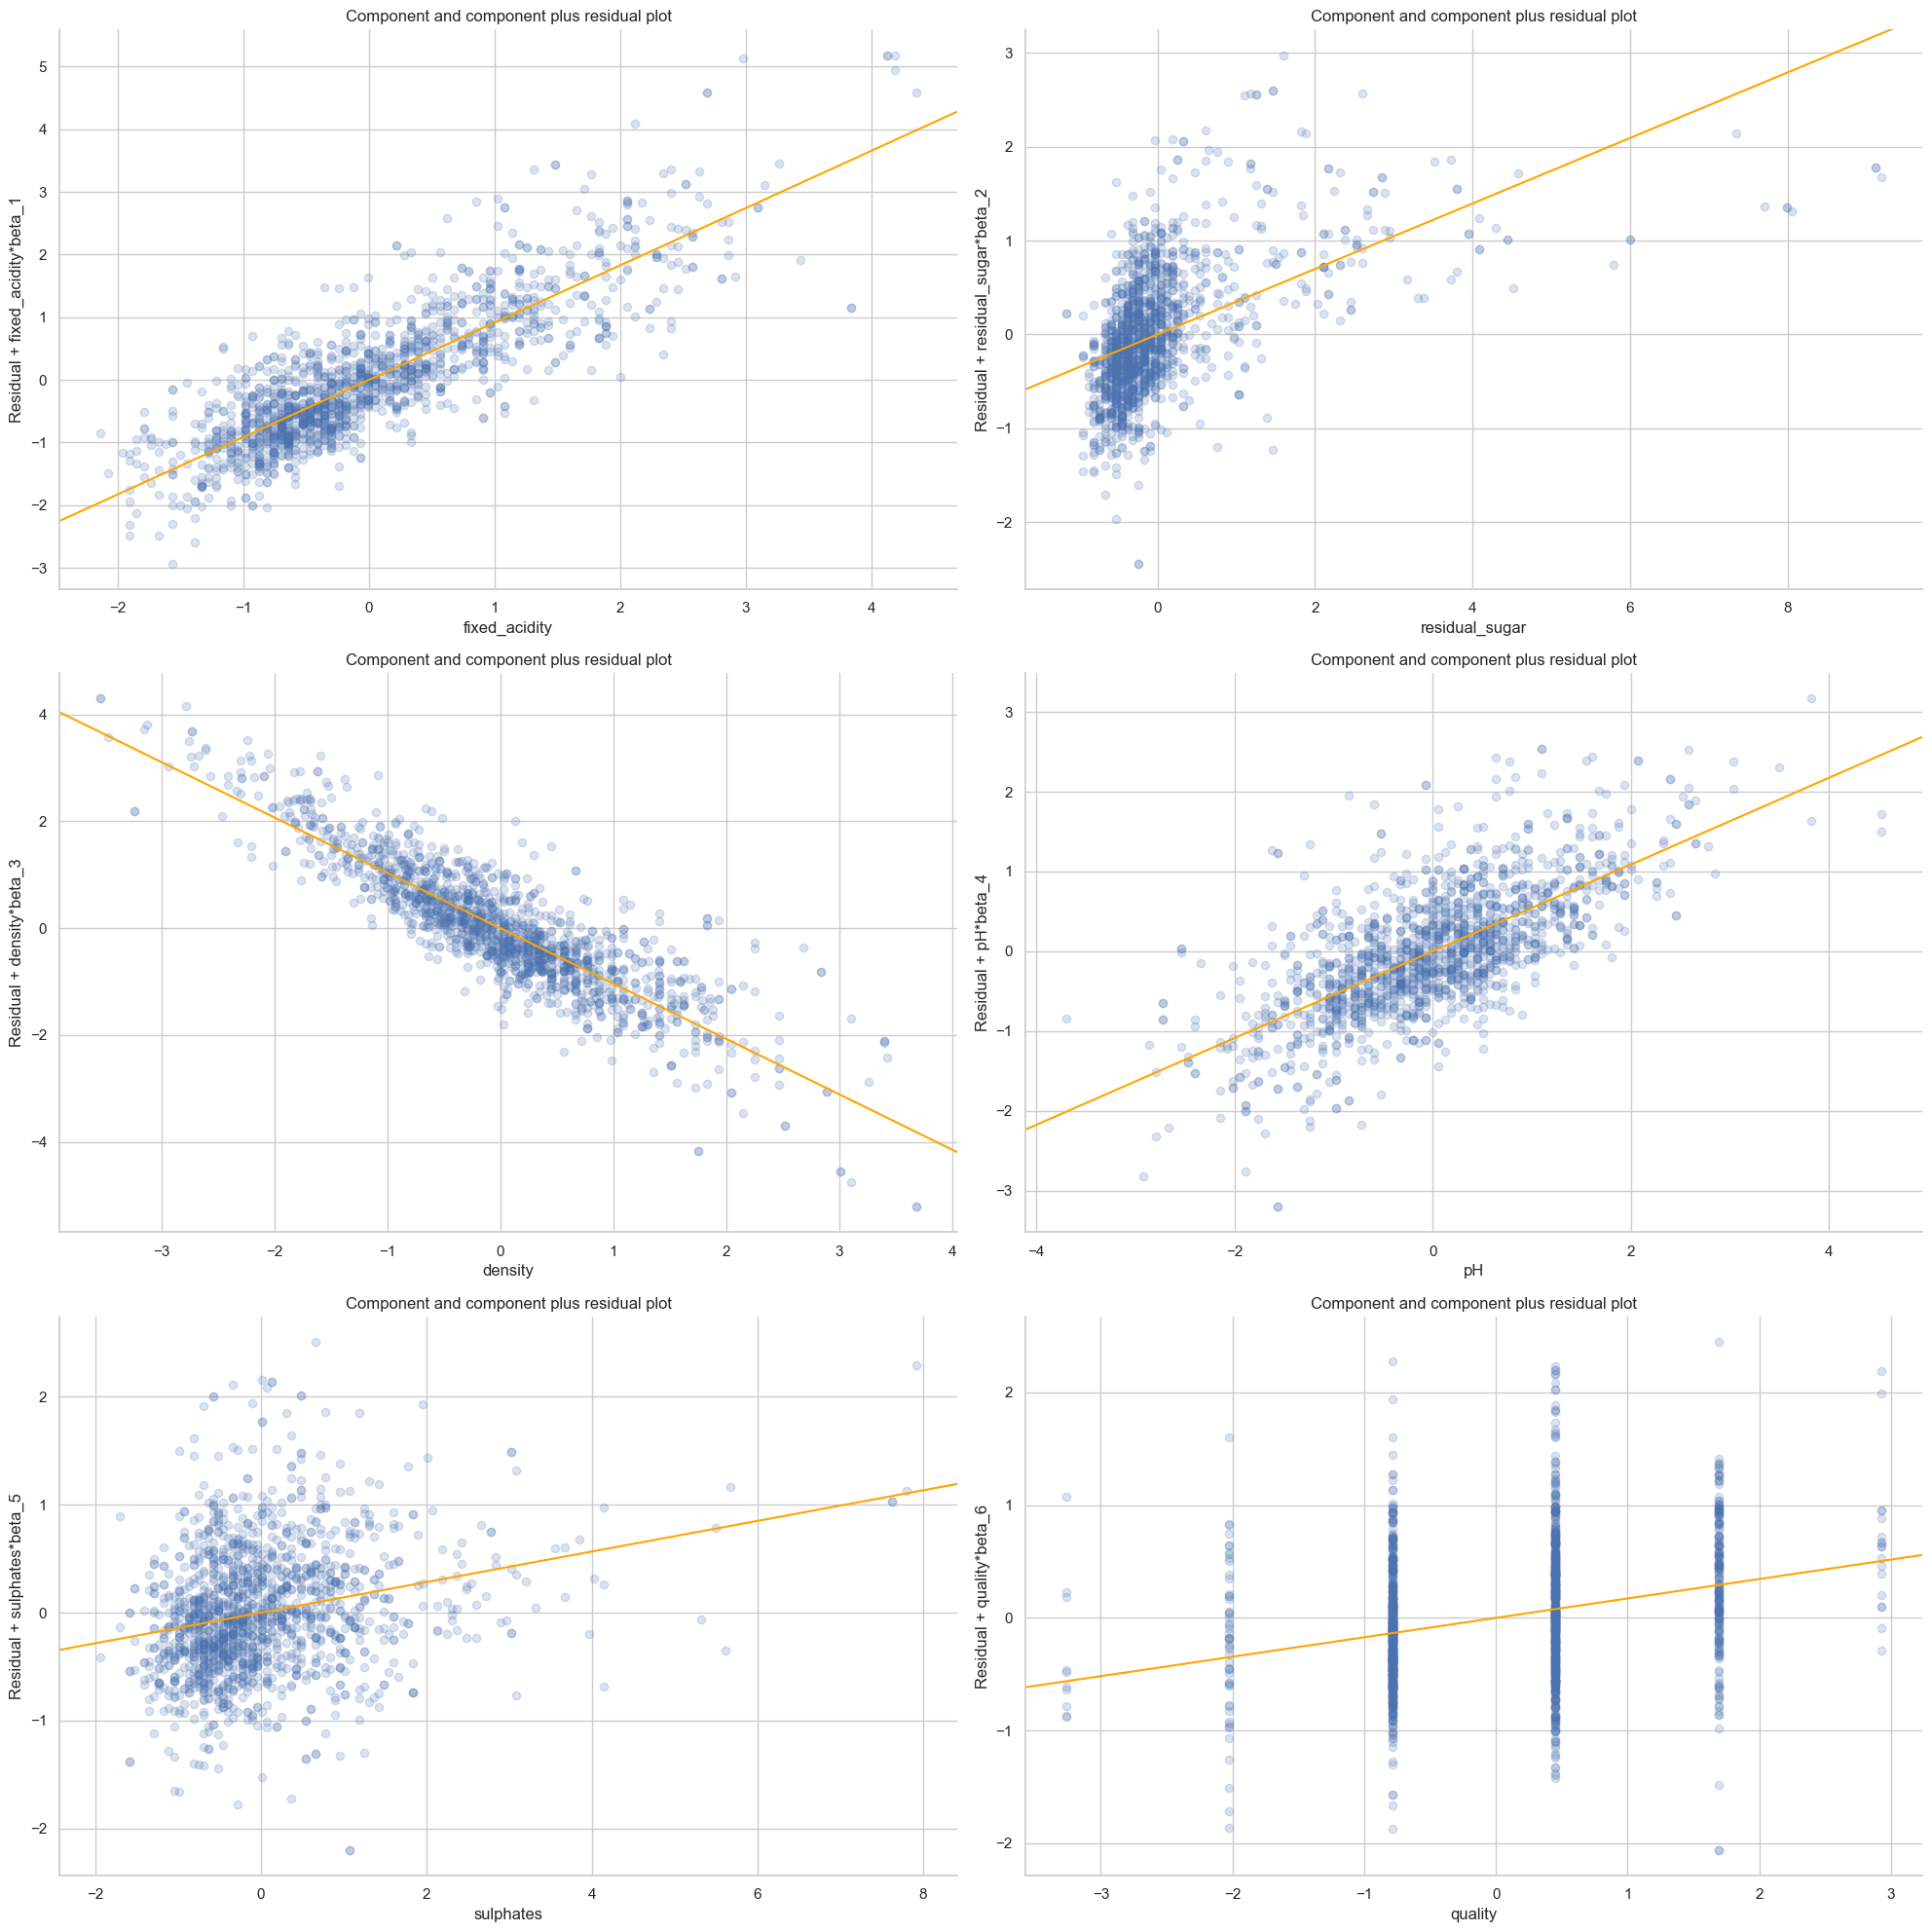

In [46]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
index = 0
for row in range(3):
    for column in range(2):
        plot_ccpr(result, ivs[index], ax[row, column])
        index += 1
        ax[row, column].lines[0].set_alpha(0.2)
        ax[row, column].lines[1].set_color('orange')
plt.tight_layout();

Residual sugar and sulphates and quality have a somewhat linear trend, but the ball shape seems to suggest a non-linear relationship which was not captured by the model.

## Cross-Validation

Benchmark RMSE:

In [47]:
benchmark = np.sqrt(np.mean(result.resid**2))
benchmark

0.5658581053695294

In [48]:
kf = KFold(n_splits=5, shuffle=True)

mse_scores = []

for train_index, test_index in kf.split(df_scaled):
    train_df = df_scaled.iloc[train_index]
    test_df = df_scaled.iloc[test_index]
    model = smf.ols(formula=formula, data=train_df).fit()
    y_pred = model.predict(test_df) 
    mse = np.mean((test_df['alcohol'] - y_pred) ** 2)
    mse_scores.append(mse)

rmse_scores = np.sqrt(mse_scores)

print("RMSE scores for each fold:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))
print("Difference from the benchmark RMSE:", np.absolute(benchmark - np.mean(rmse_scores)))

RMSE scores for each fold: [0.54343583 0.57504614 0.58728667 0.58028394 0.55677886]
Average RMSE: 0.5685662890402465
Difference from the benchmark RMSE: 0.0027081836707171236


The model seems to generalize quite well.

## Inference

$$
\begin{align*}
\text{Null Hypothesis } (H_0):& \quad \beta_x = 0 \\
\text{Alternative Hypothesis } (H_a):& \quad \beta_x \neq 0 \\
\alpha = 0.05
\end{align*}
$$


In [49]:
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.786e-14,0.014,-2.67e-12,1.000,-0.028,0.028
fixed_acidity,0.9147,0.027,33.273,0.000,0.861,0.969
residual_sugar,0.3486,0.016,22.095,0.000,0.318,0.380
density,-1.0361,0.023,-44.176,0.000,-1.082,-0.990
pH,0.5440,0.020,26.644,0.000,0.504,0.584
sulphates,0.1418,0.015,9.324,0.000,0.112,0.172
quality,0.1724,0.016,10.583,0.000,0.140,0.204


- The Intercept term fails the hypothesis test. This makes sense since the data was centered around zero. When the predictors are of their average values the dependent variable is expected to be 0. Thus, we reject the null hypothesis.
- For the rest of the coefficients we don't reject the null hypothesis.
- **Density**, **fixed acidity** and **pH** are the best predictors in this model. An increase of one standard deviation in the independent variable is associated with an increase/decrease of -1, 0.91, 0.54 standard deviations of alcohol respectively, assuming all else being fixed.

# Modeling Quality

## Encoding the variable

In [50]:
df_scaled['mediocre_good'] = df['quality'].apply(lambda x: 1 if x > 5 else 0)

## Handling inbalanced data

In [51]:
df_scaled.mediocre_good.value_counts()

mediocre_good
1    855
0    744
Name: count, dtype: int64

In [52]:
df_scaled.mediocre_good.value_counts(normalize=True).mul(100)

mediocre_good
1    53.47
0    46.53
Name: proportion, dtype: float64

In this case the inbalances don't seem critical.

## Data splitting

In [53]:
X = df_scaled.drop('mediocre_good', axis=1)
y = df_scaled['mediocre_good']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model selection

In [54]:
aic = list()
dropped = list()
rmse = list()
x_y_train_df = X_train.assign(mediocre_good=y_train)
to_exclude = ['quality', 'predicted_alcohol', 'mediocre_good']
ivs = [i for i in x_y_train_df.columns if i not in to_exclude]
added_ivs = ' + '.join(ivs)
formula_2 = f'mediocre_good ~ {added_ivs}'

In [55]:
for _ in range(len(x_y_train_df.columns) - 3):
    model = sm.GLM.from_formula(formula=formula_2, family=sm.families.Binomial(), data=x_y_train_df)
    result = model.fit()
    aic.append(result.aic)
    dropped.append(to_exclude[-1])
    rmse.append(np.sqrt(np.mean(result.resid_response**2)))
    to_exclude.append(np.absolute(result.pvalues[1:]).idxmax())
    ivs = [i for i in x_y_train_df.columns if i not in to_exclude]
    added_ivs = ' + '.join(ivs)
    formula_2 = f'mediocre_good ~ {added_ivs}'

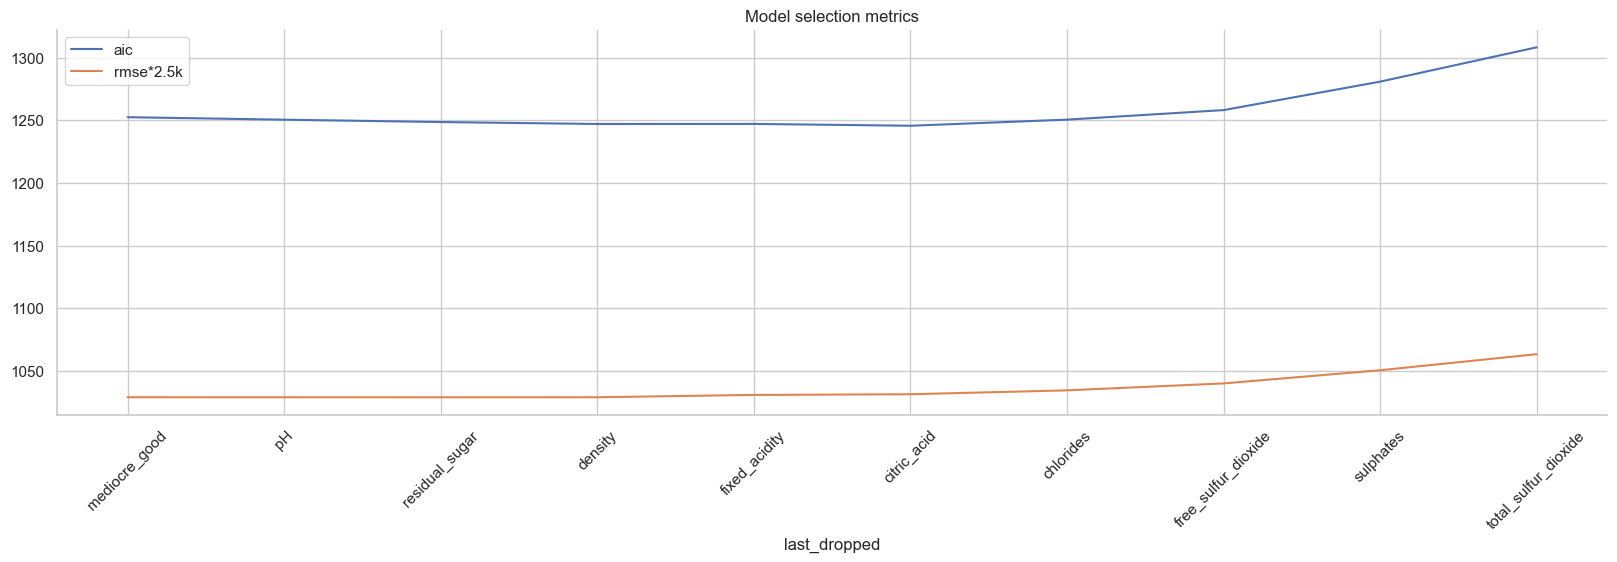

In [56]:
selection_result_2 = pd.DataFrame({'last_dropped': dropped, 'aic': aic, 'rmse*2.5k': rmse})
selection_result_2['rmse*2.5k'] = selection_result_2['rmse*2.5k'] * 2500

ax = selection_result_2.plot(x='last_dropped', kind='line', figsize=(20,5))
ax.set_title('Model selection metrics')

plt.xticks(rotation=45)
plt.xticks(ticks=range(len(selection_result_2['last_dropped'])), labels=selection_result_2['last_dropped']);

We'll drop:
- mediocre_good
- pH
- residual sugar
- density
- fixed_acidity
- citric_acid

## Model specification

The logistic regression model specification for predicting the probability that `mediocre_good` equals 1, based on selected wine characteristics, is given by:

\begin{align*}
\log\left(\frac{P(\text{mediocre\_good} = 1)}{1 - P(\text{mediocre\_good} = 1)}\right) = & \ \beta_0 + \beta_1 \times \text{chlorides} + \beta_2 \times \text{free\_sulfur\_dioxide} + \\
& \ \beta_3 \times \text{sulphates} + \beta_4 \times \text{total\_sulfur\_dioxide} + \\
& \ \beta_5 \times \text{volatile\_acidity}
\end{align*}

A classification threshold of 0.5 is applied.

## Fitting the model

In [57]:
ivs_2 = to_exclude[8:]
added_ivs = ' + '.join(ivs_2)
formula_2 = f'mediocre_good ~ {added_ivs}'
model = sm.GLM.from_formula(formula=formula_2, family=sm.families.Binomial(), data=x_y_train_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          mediocre_good   No. Observations:                 1199
Model:                            GLM   Df Residuals:                     1193
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -688.80
Date:                Mon, 12 Feb 2024   Deviance:                       1377.6
Time:                        19:52:14   Pearson chi2:                 1.37e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2088
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1327      0.066      2.017      0.044       0.004       0.262
chlorides               -0.4031      0.074     -5.464      0.000      -0.548      -0.259
free_sulfur_dioxide      0.3771      0.094      3.996      0.000       0.192       0.562
sulphates                0.5822      0.082      7.132      0.000       0.422       0.742
total_sulfur_dioxide    -0.8832      0.104     -8.506      0.000      -1.087      -0.680
volatile_acidity        -0.5221      0.073     -7.124      0.000      -0.666      -0.378
========================================================================================
"""

# Evaluation

## Multicolinearity

In [58]:
calc_vif(X_train[to_exclude[8:]]).T

,0,1,2,3,4
variable,chlorides,free_sulfur_dioxide,sulphates,total_sulfur_dioxide,volatile_acidity
VIF,1.21,1.81,1.3,1.83,1.13


## Partial residuals

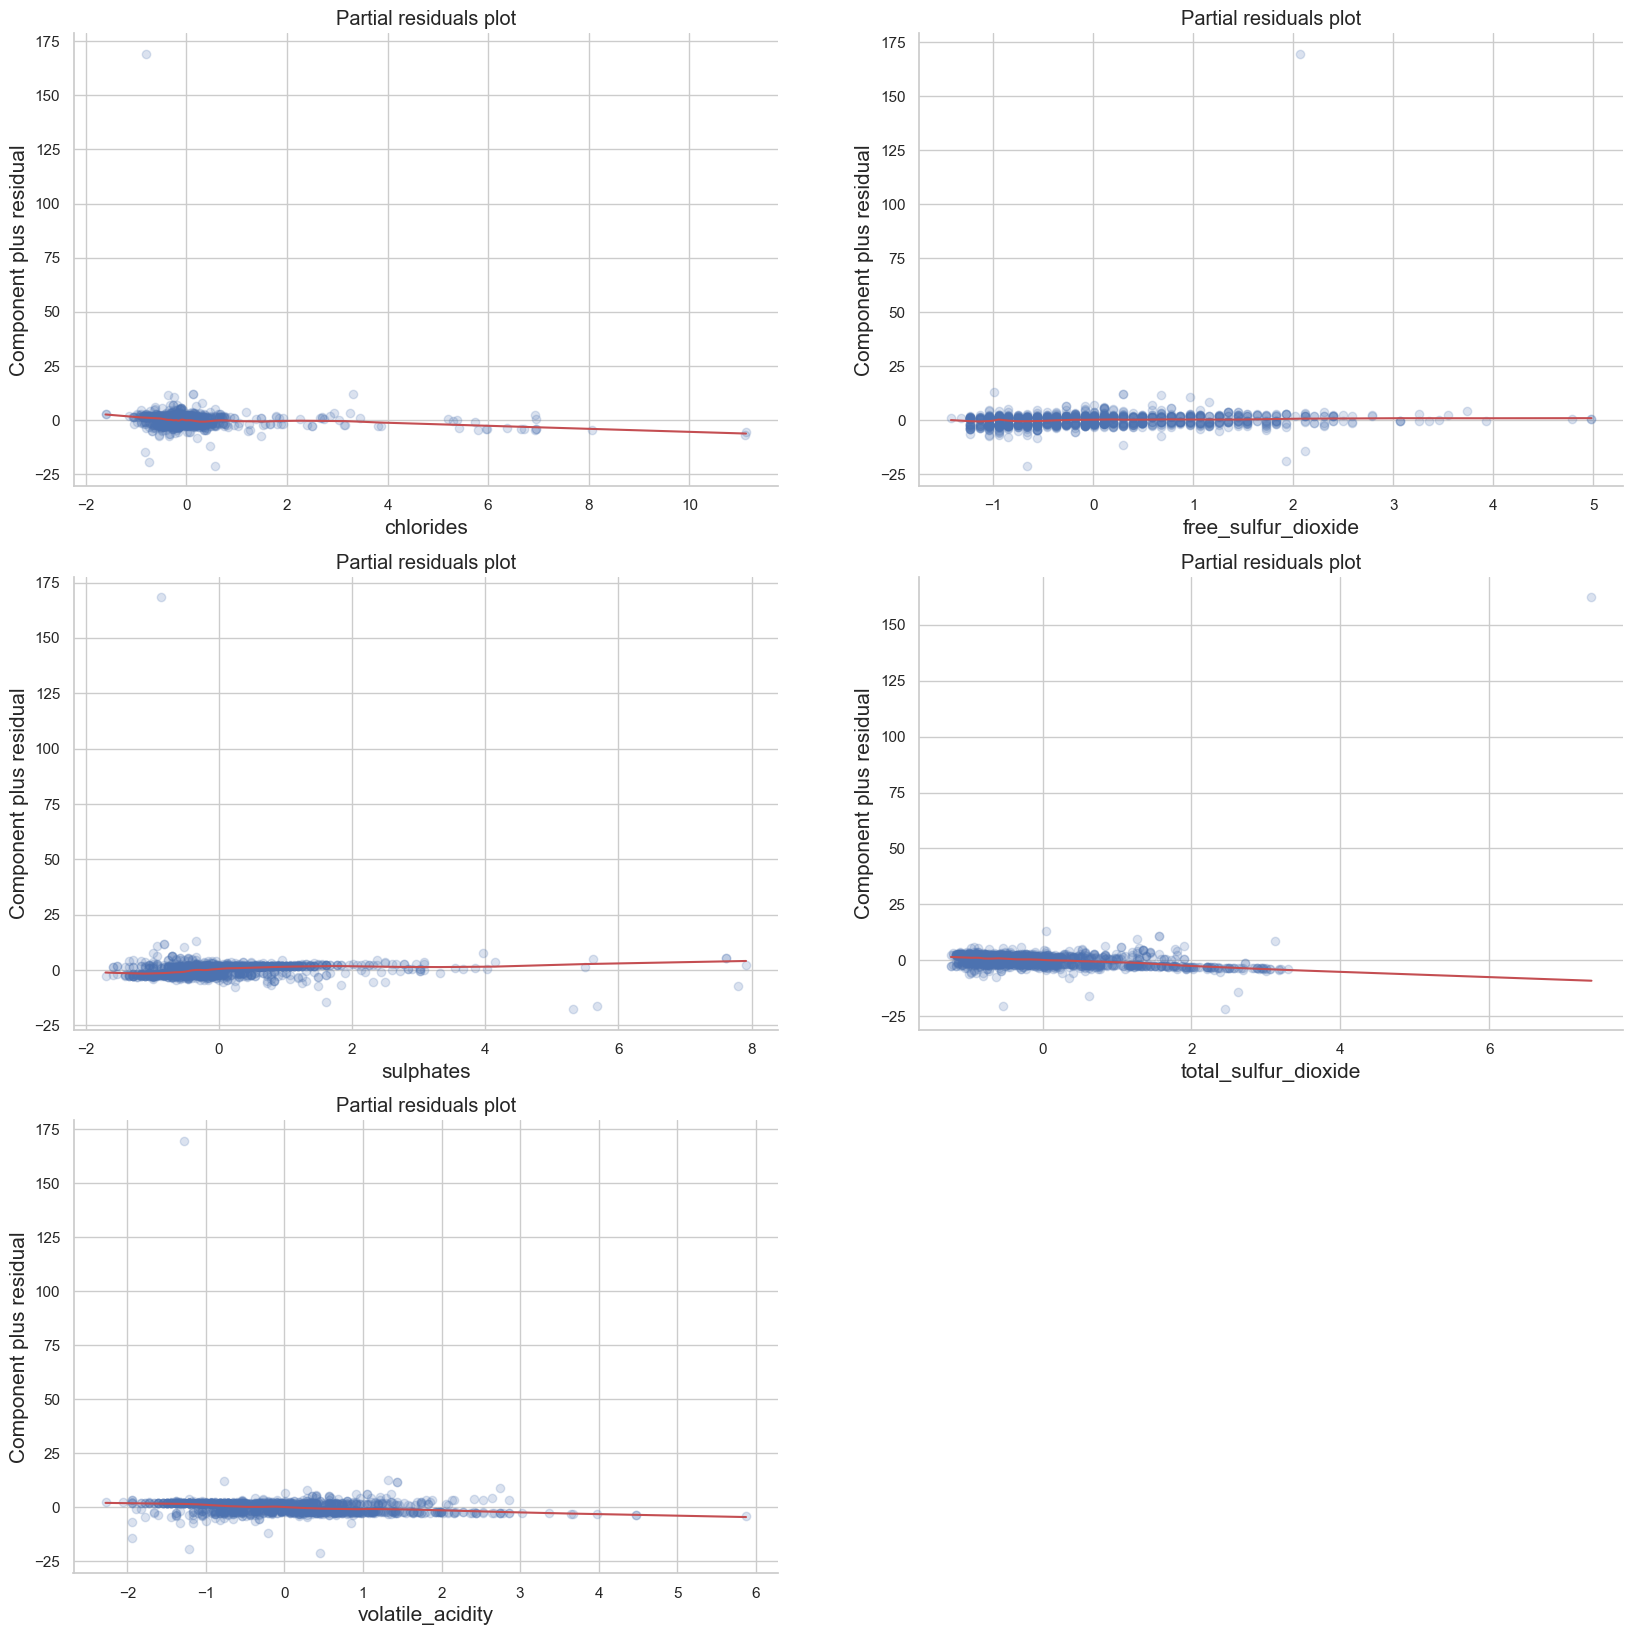

In [59]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))

index = 0
for row in range(3):
    for column in range(2):
        if index < len(ivs_2): 
            result.plot_partial_residuals(ivs_2[index], ax[row, column])
            ax[row, column].lines[0].set_alpha(0.2)
            add_lowess(ax[row, column])
            index += 1
        else:
            ax[row, column].set_visible(False)

There seem to be a few extreame outliers.

## Confusion Matrix

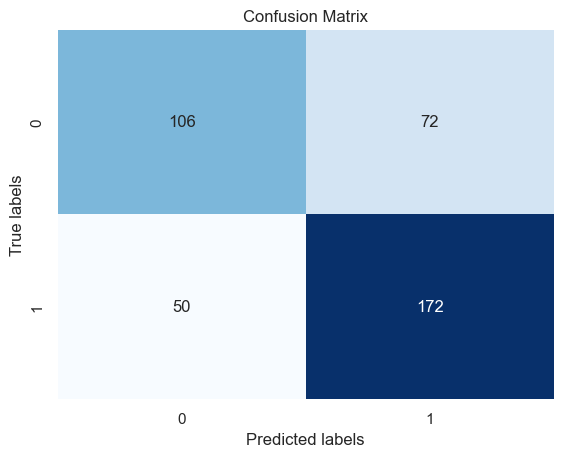

In [60]:
predicted_probabilities = result.predict(X_test)
predicted_labels = (predicted_probabilities > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix');

Quite a large number of false positives/negatives.

## Accuracy, Precision, Recall and F1 Score

In [61]:
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
TN, FP, FN, TP = conf_matrix.ravel()
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")

Accuracy: 0.695
Precision: 0.7049180327868853
Recall: 0.7747747747747747
Specificity: 0.5955056179775281
F1 Score: 0.7381974248927039


If one needs to make a decision about wine in a practical context, one generally would want to avoid missclassifying bad wines as good as much as possible and in this case the most important metric would be precision which is around 70%.

## Cross-validation

## ROC, AUC, PR curve

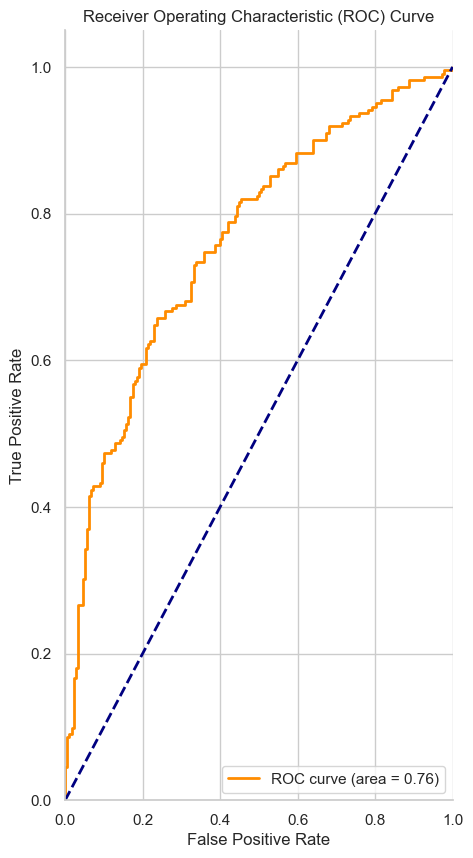

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right");

AUC of 0.76 is fair. For a more balanced model it seems like a good threshold lies on the points around 0.73 tpr and 0.36 fpr.

In [63]:
df_threshold = pd.DataFrame(dict(tpr=tpr, fpr=fpr, threshold=thresholds))

In [64]:
df_threshold_filtered = df_threshold[(df_threshold['tpr'] > 0.63) & (df_threshold['tpr'] <  0.78)] # Getting the approx. range
cond = (df_threshold_filtered['tpr'] - df_threshold_filtered['fpr']) 
df_threshold_filtered[cond == cond.max()] # Maximum difference to find the exact point

,tpr,fpr,threshold
80,0.66,0.24,0.57


We will plug in 0.57 now:

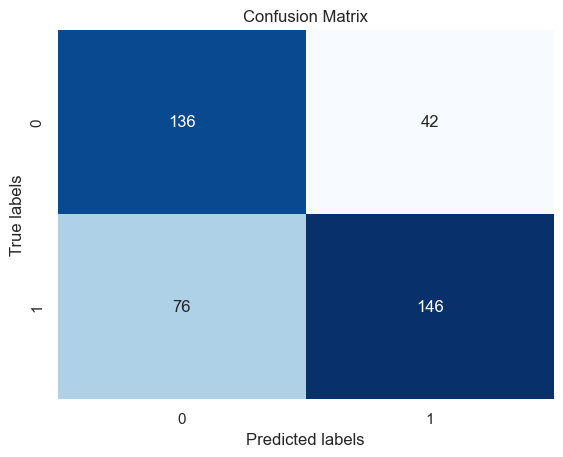

In [65]:
predicted_probabilities = result.predict(X_test)
predicted_labels = (predicted_probabilities > 0.57).astype(int)
conf_matrix = confusion_matrix(y_test, predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix');

In [66]:
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
TN, FP, FN, TP = conf_matrix.ravel()
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")

Accuracy: 0.705
Precision: 0.776595744680851
Recall: 0.6576576576576577
Specificity: 0.7640449438202247
F1 Score: 0.7121951219512195


A slight improvement in accuracy and a pretty good improvement in precision and specificity, of course, at the expense of more false positives.

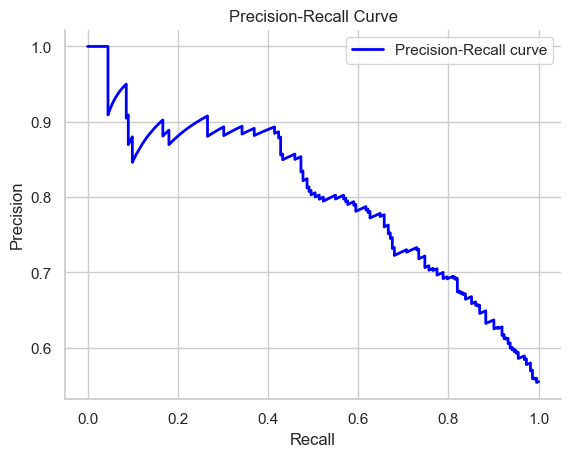

In [67]:
precision, recall, thresholds = precision_recall_curve(y_test, predicted_probabilities)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right");

From PR plot it seems as though we get the best trade-off when recall is around 0.23

In [68]:
recall_idx = np.where(recall >= 0.23)[0][-1]

In [69]:
precision[recall_idx]

0.896551724137931

In [70]:
thresholds[recall_idx]

0.8016887027400053

This threshold would result in numerous false negatives.
However, if a practical application requires confidence in goodness of wine based on chemical characteristics and we don't really care about missclassifying a bunch of otherwise good wines as bad, this threshold might be a candidate.

## Coefficient analysis

$$
\begin{align*}
\text{Null Hypothesis } (H_0):& \quad \beta_x = 0 \\
\text{Alternative Hypothesis } (H_a):& \quad \beta_x \neq 0 \\
\alpha = 0.05
\end{align*}
$$

In [71]:
result.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.1327,0.066,2.017,0.044,0.004,0.262
chlorides,-0.4031,0.074,-5.464,0.000,-0.548,-0.259
free_sulfur_dioxide,0.3771,0.094,3.996,0.000,0.192,0.562
sulphates,0.5822,0.082,7.132,0.000,0.422,0.742
total_sulfur_dioxide,-0.8832,0.104,-8.506,0.000,-1.087,-0.680
volatile_acidity,-0.5221,0.073,-7.124,0.000,-0.666,-0.378


Based on the p-value and the sample we don't reject the null hypothesis for any of the coefficients.\

## Odds ratios

We will exponentiate log odds to get odds.

In [72]:
odds_ratios = np.exp(result.params)
conf_intervals = result.conf_int()
conf_intervals_odds = np.exp(conf_intervals)
p_values = result.pvalues
summary_df = pd.DataFrame({
    "Coefficients": result.params,
    "Odds Ratios": odds_ratios,
    "P-Values": p_values,
    "CI 2.5%": conf_intervals_odds[0],
    "CI 97.5%": conf_intervals_odds[1]
})
summary_df

,Coefficients,Odds Ratios,P-Values,CI 2.5%,CI 97.5%
Intercept,0.13,1.14,4.37e-02,1.00,1.30
chlorides,-0.40,0.67,4.64e-08,0.58,0.77
free_sulfur_dioxide,0.38,1.46,6.44e-05,1.21,1.75
sulphates,0.58,1.79,9.88e-13,1.53,2.10
total_sulfur_dioxide,-0.88,0.41,1.80e-17,0.34,0.51
volatile_acidity,-0.52,0.59,1.05e-12,0.51,0.68


Total_sulfur_dioxide, sulphates and volatile_acidity are the strongest predictors of quality. When a predictor variable increases by one standard deviation the odds of dependent variable being 1 increase/decrease by: 0.41, 1.79, 0.59 respectively.